# 07.3j: Statistical Analysis of Degenerate Token Corpus

**Goal:** Deep statistical analysis of the 2,211 degenerate tokens (black holes + kissing cousins).

**Questions:**

## Token ID Analysis
- Where do these tokens fall in the vocabulary? (0-151,935)
- What's the distribution? (early bytes? late rare sequences?)
- How does token ID correlate with BPE "depth" (complexity)?
- Do high-ID tokens show more degeneracy?

## Character Classification
- What's the first "real" character of each token? (strip whitespace/symbols)
- Clean taxonomy: Thai-initiated, CJK-initiated, Arabic, Latin, etc.
- Can we definitively say "X% are Thai tokens"?

## Correlations
- Token ID vs string length
- Token ID vs character type
- Degeneracy vs token ID (black holes only)

## Parameters

In [4]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Kissing cluster
KISSING_FILE = "kissing_cluster_lat23_lon164.safetensors"
KISSING_KEY = "token_ids"

# Black holes
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Gamma matrix (for deduplication)
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

RANDOM_SEED = 42

## Imports

In [5]:
import torch
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
import unicodedata
from collections import Counter, defaultdict
from scipy import stats

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Load Tokenizer and Data

In [6]:
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
vocab_size = len(tokenizer)
print(f"  Vocabulary size: {vocab_size:,}")
print()

data_dir = Path(TENSOR_DIR)

# Load kissing cluster
print("Loading kissing cluster...")
kissing_data = load_file(data_dir / KISSING_FILE)
kissing_ids = kissing_data[KISSING_KEY].cpu().numpy()
n_kissing = len(kissing_ids)
print(f"  Kissing cluster: {n_kissing} tokens")
print()

# Load black holes
print("Loading black holes...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
black_hole_ids = torch.where(black_hole_mask)[0].cpu().numpy()
n_black_holes = len(black_hole_ids)
print(f"  Black holes: {n_black_holes:,} tokens")
print()

# Load gamma for deduplication
print("Loading gamma matrix for deduplication...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
black_hole_vectors = gamma[black_hole_mask]
unique_bh_vectors, inverse_indices = torch.unique(black_hole_vectors, dim=0, return_inverse=True)
bh_to_unique = inverse_indices.cpu().numpy()
n_unique_bh = len(unique_bh_vectors)
print(f"  Unique black hole vectors: {n_unique_bh}")
print()

# Combined corpus
all_token_ids = np.concatenate([black_hole_ids, kissing_ids])
n_total = len(all_token_ids)
print(f"Total degenerate tokens: {n_total:,}")
print()

Loading tokenizer: Qwen/Qwen3-4B-Instruct-2507
  Vocabulary size: 151,669

Loading kissing cluster...
  Kissing cluster: 111 tokens

Loading black holes...
  Black holes: 2,100 tokens

Loading gamma matrix for deduplication...
  Unique black hole vectors: 13

Total degenerate tokens: 2,211



## Utility: First Real Character Classification

In [7]:
def get_first_real_char(s):
    """Get first non-whitespace, non-symbol character (or None if none)."""
    for char in s:
        cat = unicodedata.category(char)
        # Skip whitespace (Zs, Zl, Zp) and most punctuation/symbols
        # But keep letters (L*), marks (M*), numbers (N*)
        if cat.startswith('L') or cat.startswith('M') or cat.startswith('N'):
            return char
    return None

def classify_char_by_script(char):
    """Classify character by Unicode script."""
    if char is None:
        return 'no-real-char'
    
    codepoint = ord(char)
    
    # Thai: U+0E00–U+0E7F
    if 0x0E00 <= codepoint <= 0x0E7F:
        return 'Thai'
    
    # CJK Unified Ideographs: U+4E00–U+9FFF
    if 0x4E00 <= codepoint <= 0x9FFF:
        return 'CJK'
    
    # CJK Compatibility Ideographs: U+F900–U+FAFF
    if 0xF900 <= codepoint <= 0xFAFF:
        return 'CJK-compat'
    
    # CJK Extension A: U+3400–U+4DBF
    if 0x3400 <= codepoint <= 0x4DBF:
        return 'CJK'
    
    # Arabic: U+0600–U+06FF
    if 0x0600 <= codepoint <= 0x06FF:
        return 'Arabic'
    
    # Cyrillic: U+0400–U+04FF
    if 0x0400 <= codepoint <= 0x04FF:
        return 'Cyrillic'
    
    # Greek: U+0370–U+03FF
    if 0x0370 <= codepoint <= 0x03FF:
        return 'Greek'
    
    # Latin: U+0000–U+024F (Basic + Extended)
    if codepoint <= 0x024F:
        return 'Latin'
    
    # Hangul: U+AC00–U+D7AF
    if 0xAC00 <= codepoint <= 0xD7AF:
        return 'Hangul'
    
    # Hebrew: U+0590–U+05FF
    if 0x0590 <= codepoint <= 0x05FF:
        return 'Hebrew'
    
    return 'Other'

def classify_token(token_id, tokenizer):
    """Classify token by its first real character."""
    try:
        s = tokenizer.decode([token_id])
    except:
        return 'decode-error', None
    
    # Special case: ChatML-like tokens
    if s.startswith('<|') and s.endswith('|>'):
        return 'special-token', None
    
    # Empty or whitespace-only
    if len(s.strip()) == 0:
        return 'empty-or-whitespace', None
    
    # Get first real character
    first_char = get_first_real_char(s)
    script = classify_char_by_script(first_char)
    
    return script, first_char

print("Classification functions defined.")

Classification functions defined.


## Decode and Classify All Tokens

In [8]:
print("Decoding and classifying all degenerate tokens...")
print()

token_data = []
for token_id in all_token_ids:
    # Decode
    try:
        s = tokenizer.decode([token_id])
    except:
        s = "<DECODE_ERROR>"
    
    # Classify
    script, first_char = classify_token(token_id, tokenizer)
    
    # Group membership
    if token_id in black_hole_ids:
        group = 'black-hole'
        # Find unique vector index
        idx_in_bh = np.where(black_hole_ids == token_id)[0][0]
        unique_idx = bh_to_unique[idx_in_bh]
    else:
        group = 'kissing-cousin'
        unique_idx = -1
    
    token_data.append({
        'token_id': int(token_id),
        'string': s,
        'length': len(s),
        'script': script,
        'first_char': first_char,
        'group': group,
        'unique_idx': unique_idx
    })

print(f"Classified {len(token_data):,} tokens.")
print()

Decoding and classifying all degenerate tokens...

Classified 2,211 tokens.



## Token ID Statistics

In [9]:
print("="*100)
print("TOKEN ID STATISTICS")
print("="*100)
print()

token_ids_array = np.array([t['token_id'] for t in token_data])

print(f"Vocabulary size: {vocab_size:,}")
print(f"Token ID range:  0 to {vocab_size-1:,}")
print()

print(f"Degenerate token IDs:")
print(f"  Count:       {len(token_ids_array):,}")
print(f"  Min:         {token_ids_array.min():,}")
print(f"  Max:         {token_ids_array.max():,}")
print(f"  Mean:        {token_ids_array.mean():,.1f}")
print(f"  Median:      {np.median(token_ids_array):,.0f}")
print(f"  Std:         {token_ids_array.std():,.1f}")
print()

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"Percentiles:")
for p in percentiles:
    val = np.percentile(token_ids_array, p)
    pct_of_vocab = 100 * val / vocab_size
    print(f"  {p:2d}th: {val:8,.0f}  ({pct_of_vocab:5.1f}% through vocabulary)")
print()

# BPE depth analysis
n_bytes = (token_ids_array < 256).sum()
n_low = (token_ids_array < 10000).sum()
n_mid = ((token_ids_array >= 10000) & (token_ids_array < 100000)).sum()
n_high = (token_ids_array >= 100000).sum()

print(f"BPE depth distribution:")
print(f"  0-255 (bytes):           {n_bytes:5d} ({100*n_bytes/len(token_ids_array):5.1f}%)")
print(f"  256-9,999 (early):       {n_low-n_bytes:5d} ({100*(n_low-n_bytes)/len(token_ids_array):5.1f}%)")
print(f"  10,000-99,999 (mid):     {n_mid:5d} ({100*n_mid/len(token_ids_array):5.1f}%)")
print(f"  100,000+ (late/rare):    {n_high:5d} ({100*n_high/len(token_ids_array):5.1f}%)")
print()

print(f"Interpretation: {100*n_high/len(token_ids_array):.1f}% of degenerate tokens are in the high-ID range.")
print(f"These are rare, complex multi-byte sequences that appear late in BPE merging.")
print()

TOKEN ID STATISTICS

Vocabulary size: 151,669
Token ID range:  0 to 151,668

Degenerate token IDs:
  Count:       2,211
  Min:         124
  Max:         151,935
  Mean:        137,008.6
  Median:      137,626
  Std:         13,826.4

Percentiles:
  10th:  125,891  ( 83.0% through vocabulary)
  25th:  130,192  ( 85.8% through vocabulary)
  50th:  137,626  ( 90.7% through vocabulary)
  75th:  143,518  ( 94.6% through vocabulary)
  90th:  151,714  (100.0% through vocabulary)
  95th:  151,824  (100.1% through vocabulary)
  99th:  151,913  (100.2% through vocabulary)

BPE depth distribution:
  0-255 (bytes):              13 (  0.6%)
  256-9,999 (early):           0 (  0.0%)
  10,000-99,999 (mid):         2 (  0.1%)
  100,000+ (late/rare):     2196 ( 99.3%)

Interpretation: 99.3% of degenerate tokens are in the high-ID range.
These are rare, complex multi-byte sequences that appear late in BPE merging.



## Script Classification Statistics

In [10]:
print("="*100)
print("SCRIPT CLASSIFICATION STATISTICS")
print("="*100)
print()

script_counts = Counter([t['script'] for t in token_data])

print(f"All degenerate tokens ({n_total:,} total):")
print()
for script, count in script_counts.most_common():
    pct = 100 * count / n_total
    print(f"  {script:25s}: {count:5d} ({pct:5.1f}%)")
print()

# By group
bh_scripts = Counter([t['script'] for t in token_data if t['group'] == 'black-hole'])
kc_scripts = Counter([t['script'] for t in token_data if t['group'] == 'kissing-cousin'])

print(f"Black holes ({n_black_holes:,} tokens):")
print()
for script, count in bh_scripts.most_common():
    pct = 100 * count / n_black_holes
    print(f"  {script:25s}: {count:5d} ({pct:5.1f}%)")
print()

print(f"Kissing cousins ({n_kissing} tokens):")
print()
for script, count in kc_scripts.most_common():
    pct = 100 * count / n_kissing
    print(f"  {script:25s}: {count:5d} ({pct:5.1f}%)")
print()

# Thai percentage
thai_count = script_counts['Thai']
thai_pct = 100 * thai_count / n_total
print(f"✓ CONFIRMED: {thai_pct:.1f}% of degenerate tokens are Thai-initiated.")
print()

SCRIPT CLASSIFICATION STATISTICS

All degenerate tokens (2,211 total):

  Thai                     :  1579 ( 71.4%)
  empty-or-whitespace      :   267 ( 12.1%)
  CJK-compat               :   194 (  8.8%)
  Arabic                   :    75 (  3.4%)
  Other                    :    39 (  1.8%)
  no-real-char             :    22 (  1.0%)
  Latin                    :    17 (  0.8%)
  special-token            :    10 (  0.5%)
  CJK                      :     4 (  0.2%)
  Hebrew                   :     3 (  0.1%)
  Greek                    :     1 (  0.0%)

Black holes (2,100 tokens):

  Thai                     :  1493 ( 71.1%)
  empty-or-whitespace      :   263 ( 12.5%)
  CJK-compat               :   178 (  8.5%)
  Arabic                   :    74 (  3.5%)
  Other                    :    38 (  1.8%)
  no-real-char             :    21 (  1.0%)
  Latin                    :    17 (  0.8%)
  special-token            :     8 (  0.4%)
  CJK                      :     4 (  0.2%)
  Hebrew          

## Correlation: Token ID vs String Length

In [11]:
print("Correlation: Token ID vs String Length")
print()

lengths = np.array([t['length'] for t in token_data])
ids = np.array([t['token_id'] for t in token_data])

# Pearson correlation
corr, p_value = stats.pearsonr(ids, lengths)
print(f"  Pearson r:  {corr:+.3f}")
print(f"  p-value:    {p_value:.2e}")
print()

if abs(corr) > 0.5:
    print(f"  Strong {'positive' if corr > 0 else 'negative'} correlation!")
elif abs(corr) > 0.3:
    print(f"  Moderate {'positive' if corr > 0 else 'negative'} correlation.")
else:
    print(f"  Weak correlation.")
print()

print(f"String length statistics:")
print(f"  Min:    {lengths.min()}")
print(f"  Max:    {lengths.max()}")
print(f"  Mean:   {lengths.mean():.1f}")
print(f"  Median: {np.median(lengths):.0f}")
print()

Correlation: Token ID vs String Length

  Pearson r:  -0.156
  p-value:    1.67e-13

  Weak correlation.

String length statistics:
  Min:    0
  Max:    20
  Mean:   3.9
  Median: 4



## Black Hole Degeneracy Analysis

In [12]:
print("Black hole degeneracy analysis:")
print()

# Count tokens per unique vector
degeneracy_counts = Counter(bh_to_unique)
degeneracies = [degeneracy_counts[i] for i in range(n_unique_bh)]

print(f"  Unique vectors:    {n_unique_bh}")
print(f"  Total BH tokens:   {n_black_holes:,}")
print(f"  Degeneracy:")
print(f"    Min:    {min(degeneracies)}")
print(f"    Max:    {max(degeneracies)}")
print(f"    Mean:   {np.mean(degeneracies):.1f}")
print(f"    Median: {np.median(degeneracies):.0f}")
print()

# Top 5 most degenerate vectors
print(f"Top 5 most degenerate unique vectors:")
sorted_indices = np.argsort(degeneracies)[::-1]
for rank, idx in enumerate(sorted_indices[:5], 1):
    deg = degeneracies[idx]
    print(f"  {rank}. Vector {idx}: {deg} tokens")
print()

Black hole degeneracy analysis:

  Unique vectors:    13
  Total BH tokens:   2,100
  Degeneracy:
    Min:    2
    Max:    814
    Mean:   161.5
    Median: 6

Top 5 most degenerate unique vectors:
  1. Vector 5: 814 tokens
  2. Vector 10: 704 tokens
  3. Vector 3: 306 tokens
  4. Vector 6: 228 tokens
  5. Vector 11: 11 tokens



## Visualizations

### Token ID Distribution

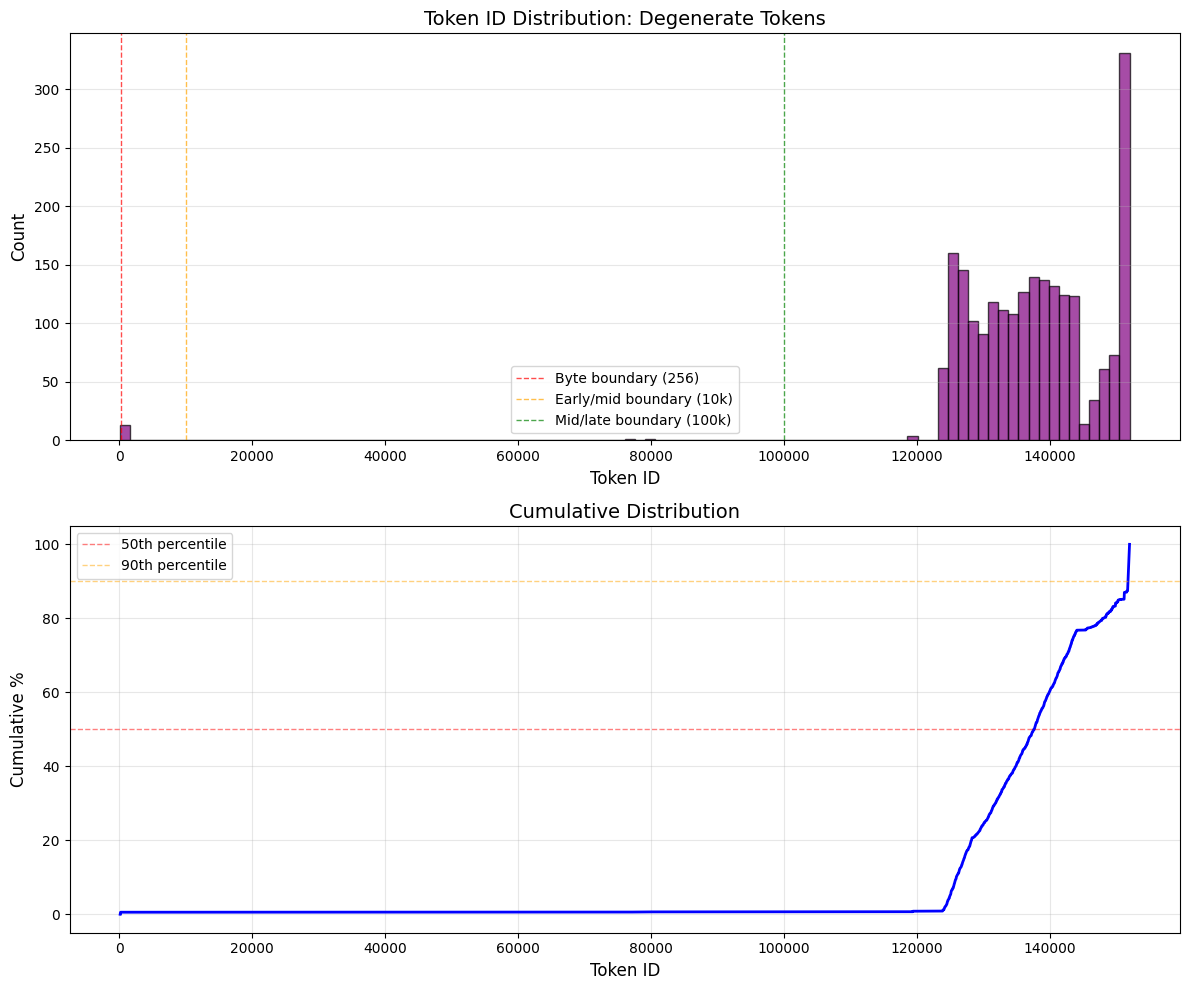

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=100)

# Histogram
ax1.hist(token_ids_array, bins=100, alpha=0.7, color='purple', edgecolor='black')
ax1.axvline(256, color='red', linestyle='--', linewidth=1, label='Byte boundary (256)', alpha=0.7)
ax1.axvline(10000, color='orange', linestyle='--', linewidth=1, label='Early/mid boundary (10k)', alpha=0.7)
ax1.axvline(100000, color='green', linestyle='--', linewidth=1, label='Mid/late boundary (100k)', alpha=0.7)
ax1.set_xlabel('Token ID', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Token ID Distribution: Degenerate Tokens', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative distribution
sorted_ids = np.sort(token_ids_array)
cumulative = np.arange(1, len(sorted_ids) + 1) / len(sorted_ids) * 100
ax2.plot(sorted_ids, cumulative, color='blue', linewidth=2)
ax2.axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50th percentile')
ax2.axhline(90, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='90th percentile')
ax2.set_xlabel('Token ID', fontsize=12)
ax2.set_ylabel('Cumulative %', fontsize=12)
ax2.set_title('Cumulative Distribution', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Script Distribution

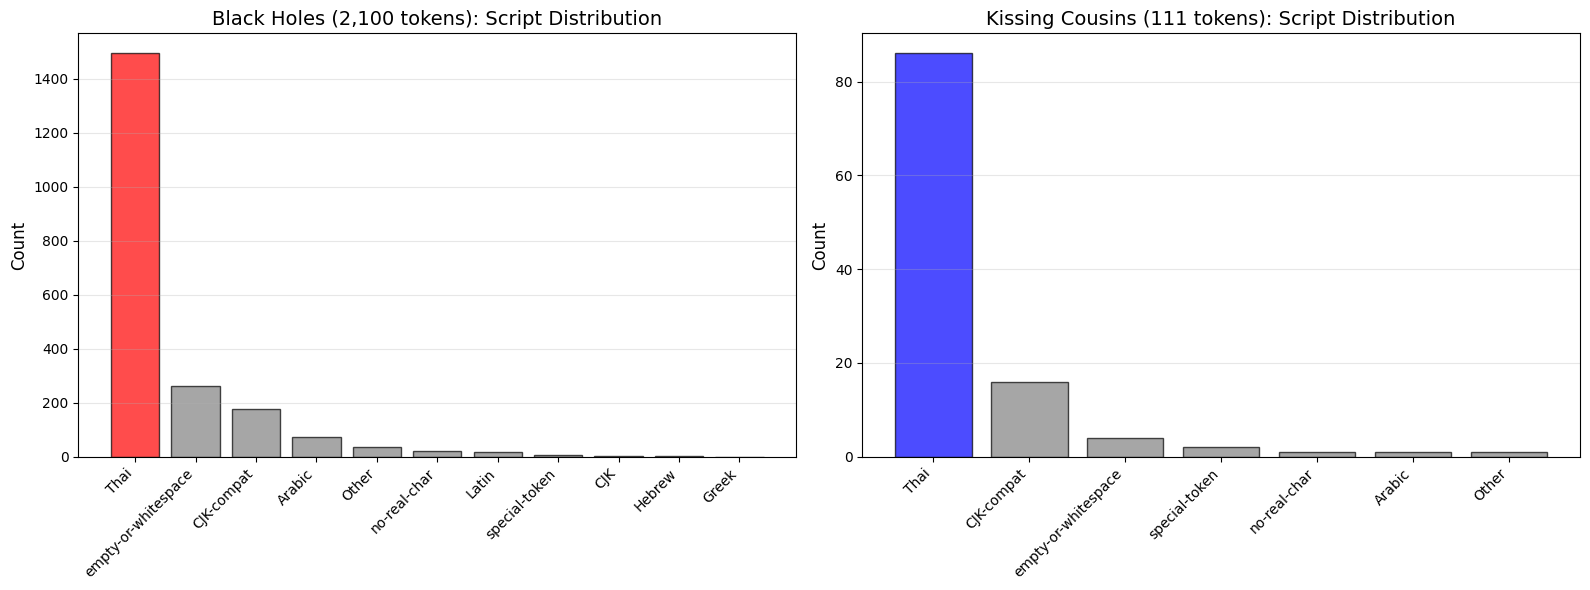

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Black holes
scripts_bh = [s for s, _ in bh_scripts.most_common()]
counts_bh = [bh_scripts[s] for s in scripts_bh]
colors_bh = ['red' if s == 'Thai' else 'gray' for s in scripts_bh]
ax1.bar(range(len(scripts_bh)), counts_bh, color=colors_bh, alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(scripts_bh)))
ax1.set_xticklabels(scripts_bh, rotation=45, ha='right')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Black Holes ({n_black_holes:,} tokens): Script Distribution', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Kissing cousins
scripts_kc = [s for s, _ in kc_scripts.most_common()]
counts_kc = [kc_scripts[s] for s in scripts_kc]
colors_kc = ['blue' if s == 'Thai' else 'gray' for s in scripts_kc]
ax2.bar(range(len(scripts_kc)), counts_kc, color=colors_kc, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(scripts_kc)))
ax2.set_xticklabels(scripts_kc, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'Kissing Cousins ({n_kissing} tokens): Script Distribution', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Token ID vs String Length

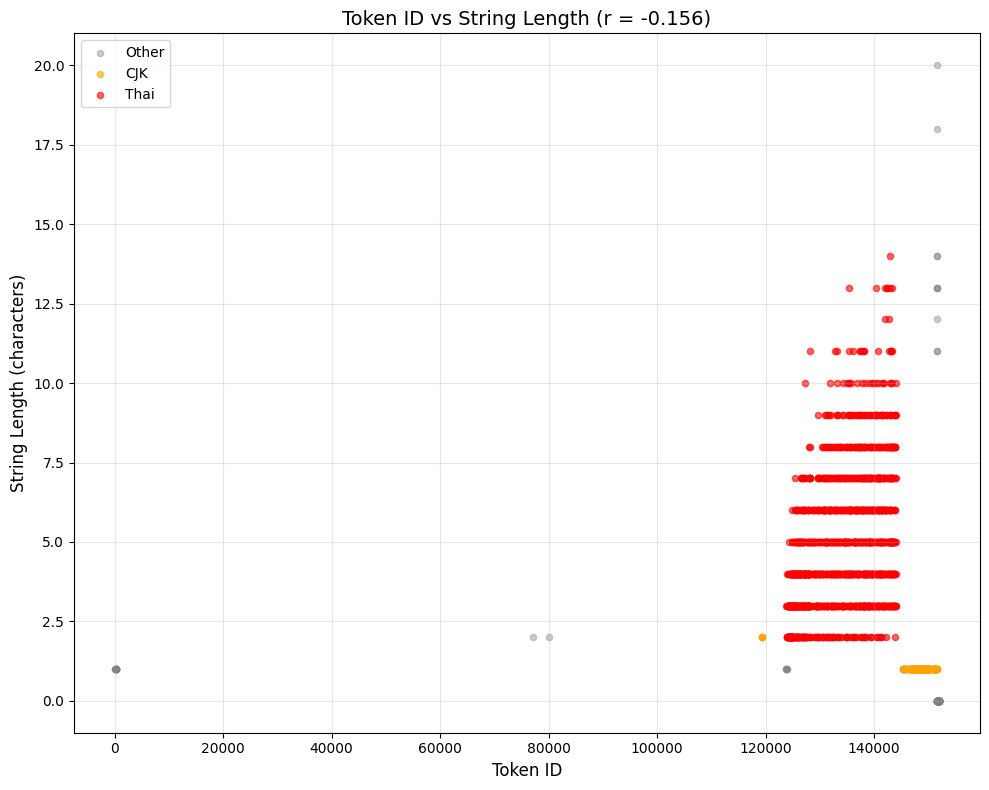

In [15]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

# Color by script
scripts = np.array([t['script'] for t in token_data])
thai_mask = scripts == 'Thai'
cjk_mask = (scripts == 'CJK') | (scripts == 'CJK-compat')
other_mask = ~(thai_mask | cjk_mask)

# Plot
ax.scatter(ids[other_mask], lengths[other_mask], s=20, alpha=0.4, c='gray', label='Other')
ax.scatter(ids[cjk_mask], lengths[cjk_mask], s=20, alpha=0.6, c='orange', label='CJK')
ax.scatter(ids[thai_mask], lengths[thai_mask], s=20, alpha=0.6, c='red', label='Thai')

ax.set_xlabel('Token ID', fontsize=12)
ax.set_ylabel('String Length (characters)', fontsize=12)
ax.set_title(f'Token ID vs String Length (r = {corr:+.3f})', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Black Hole Degeneracy Distribution

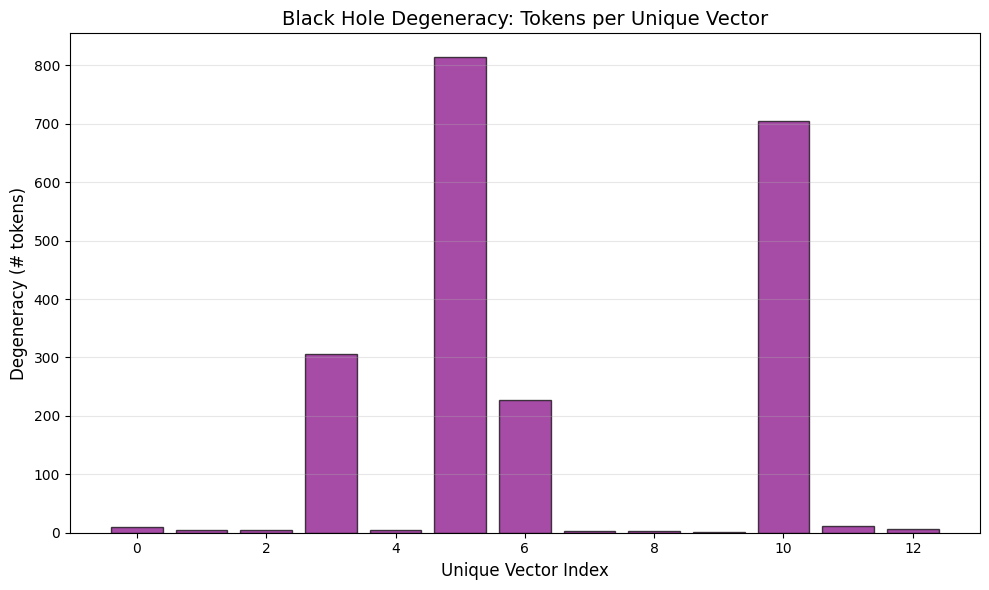

In [16]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

x = list(range(n_unique_bh))
y = degeneracies
ax.bar(x, y, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Unique Vector Index', fontsize=12)
ax.set_ylabel('Degeneracy (# tokens)', fontsize=12)
ax.set_title('Black Hole Degeneracy: Tokens per Unique Vector', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

In [17]:
print("="*100)
print("SUMMARY")
print("="*100)
print()

print(f"**Degenerate Structure:** {n_total:,} tokens collapsed to essentially one point")
print()

print(f"**Composition:**")
print(f"  - Black holes:      {n_black_holes:,} tokens (collapsed to {n_unique_bh} unique vectors)")
print(f"  - Kissing cousins:  {n_kissing} tokens (barely distinguishable at ~2× ULP)")
print()

print(f"**Token ID Profile:**")
print(f"  - Range:     {token_ids_array.min():,} to {token_ids_array.max():,}")
print(f"  - Median:    {np.median(token_ids_array):,.0f} (vocab position {100*np.median(token_ids_array)/vocab_size:.1f}%)")
print(f"  - High-ID:   {100*n_high/n_total:.1f}% are ID ≥ 100,000 (rare, late BPE merges)")
print()

print(f"**Script Classification:**")
thai_pct_overall = 100 * script_counts['Thai'] / n_total
thai_pct_bh = 100 * bh_scripts['Thai'] / n_black_holes
thai_pct_kc = 100 * kc_scripts['Thai'] / n_kissing
print(f"  - Overall:         {thai_pct_overall:.1f}% Thai")
print(f"  - Black holes:     {thai_pct_bh:.1f}% Thai")
print(f"  - Kissing cousins: {thai_pct_kc:.1f}% Thai")
print()

cjk_total = script_counts.get('CJK', 0) + script_counts.get('CJK-compat', 0)
cjk_pct = 100 * cjk_total / n_total
print(f"  - CJK (all):       {cjk_pct:.1f}%")
print()

print(f"**Interpretation:**")
print(f"  This degenerate structure is primarily composed of rare Thai tokens (~{thai_pct_overall:.0f}%)")
print(f"  that received minimal training signal. They collapsed to a single attractor point")
print(f"  at r ≈ 0.122, unable to develop distinct representations.")
print()
print(f"  The high token IDs (median {np.median(token_ids_array):,.0f}) confirm these are late-stage")
print(f"  BPE merges: complex multi-byte sequences that appear rarely in text.")
print()
print(f"  **This is a training data sparsity artifact.**")
print()

SUMMARY

**Degenerate Structure:** 2,211 tokens collapsed to essentially one point

**Composition:**
  - Black holes:      2,100 tokens (collapsed to 13 unique vectors)
  - Kissing cousins:  111 tokens (barely distinguishable at ~2× ULP)

**Token ID Profile:**
  - Range:     124 to 151,935
  - Median:    137,626 (vocab position 90.7%)
  - High-ID:   99.3% are ID ≥ 100,000 (rare, late BPE merges)

**Script Classification:**
  - Overall:         71.4% Thai
  - Black holes:     71.1% Thai
  - Kissing cousins: 77.5% Thai

  - CJK (all):       9.0%

**Interpretation:**
  This degenerate structure is primarily composed of rare Thai tokens (~71%)
  that received minimal training signal. They collapsed to a single attractor point
  at r ≈ 0.122, unable to develop distinct representations.

  The high token IDs (median 137,626) confirm these are late-stage
  BPE merges: complex multi-byte sequences that appear rarely in text.

  **This is a training data sparsity artifact.**

